# Cluster and HII-regions

the aim of this notebook is to combine the HII-region and cluster catalogues

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from pymuse.packages import *

from pymuse.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
logging.basicConfig(stream=sys.stdout,
                    #format='(levelname)s %(name)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

## Read in data

| name    | HST | MUSE |
|---------|-----|------|
| IC5332  | f   | DR1  |
| NGC0628 | yes | DR1  |
| NGC1087 | yes | DR1  |
| NGC1300 | wait| DR2  |
| NGC1365 | yes | DR1  |
| NGC1385 | wait| DR2  |
| NGC1433 | not | DR2  |
| NGC1512 | not | DR1  |
| NGC1566 | *yes | DR1  |
| NGC1672 |     | DR1  |
| NGC2835 |     | DR1  |
| NGC3351 | *yes | DR1  |
| NGC3627 |     | DR1  |
| NGC4254 |     | DR1  |
| NGC4303 |     | DR2  |
| NGC4321 |     | wait |
| NGC4535 |     | DR1  |
| NGC5068 |     | DR1  |
| NGC7496 |     | DR2  |


In [3]:
from pymuse.io import ReadLineMaps
from pymuse.auxiliary import filter_table

name = 'NGC1566'

# first we need to specify the path to the raw data
data_raw = Path('d:\downloads\MUSEDAP')
data_ext = Path('g:\Archive')
basedir = Path('..')

In [5]:
# read in the data we will be working with and print some information
galaxy = ReadLineMaps(data_raw,name)

with open(basedir / 'data' / 'interim' / 'parameters.yml') as yml_file:
    parameters = yaml.load(yml_file,Loader=yaml.FullLoader)
    
setattr(galaxy,'aperturesize',parameters[galaxy.name]['aperturesize'])
setattr(galaxy,'binsize',parameters[galaxy.name]['binsize'])
setattr(galaxy,'mu',parameters[galaxy.name]['mu'])
setattr(galaxy,'alpha',parameters[galaxy.name]['power_index'])
setattr(galaxy,'completeness_limit',parameters[galaxy.name]['completeness_limit'])
setattr(galaxy,'roundness',parameters[galaxy.name]['roundness'])
setattr(galaxy,'sharplo',parameters[galaxy.name]['sharplo'])
setattr(galaxy,'sharphi',parameters[galaxy.name]['sharphi'])
setattr(galaxy,'threshold',parameters[galaxy.name]['threshold'])
setattr(galaxy,'zoomin',parameters[galaxy.name]['zoomin'])

INFO:pymuse.io:loading NGC1566
INFO:pymuse.io:replacing OIII5006 map
INFO:pymuse.io:file loaded with 4 extensions


In [13]:
# nebulae catalogue from Francesco (mostly HII-regions)
with fits.open(basedir / 'data' / 'external' / 'Nebulae_Catalogue.fits') as hdul:
    nebulae = Table(hdul[1].data)
    
nebulae = nebulae[nebulae['gal_name']==name]    
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])

#nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')

nebulae = filter_table(nebulae,BPT_NII=0,BPT_SII=0,BPT_OI=0,flag_star=0)

nebulae = nebulae[['region_ID','x','y','met_scal','Delta_met','logq_D91']]
nebulae.rename_columns(['region_ID','met_scal','Delta_met','logq_D91'],['ID','Z','Z_local','ionization'])
nebulae['SkyCoord'] = SkyCoord.from_pixel(nebulae['x'],nebulae['y'],galaxy.wcs)

print(f'{len(nebulae)} nebulae in catalogue')

1010 nebulae in catalogue


In [7]:
# whitelight image

filename = data_ext / 'HST' / name / 'white_light' / f'{name.lower()}_white_24rgb.fits'

with fits.open(filename) as hdul:
    hst_whitelight = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    hst_whitelight.data[hst_whitelight.data==0] = np.nan

In [ ]:
filename = data_ext / 'MUSE' / 'MUSEDAP' / name / f'{name}_MAPS.fits'
with fits.open(filename) as hdul:
    muse_whitelight = NDData(hdul['FLUX'].data,meta=hdul['FLUX'].header,wcs=WCS(hdul['FLUX'].header))   

In [8]:
# cluster catalogues

filename = data_ext / 'HST' / name / 'clusters_photometry_v0_9' / f'{name}_phangshst_cluster_allcandidates_v0_9.fits'

with fits.open(filename) as hdul:
    clusters = Table(hdul[1].data)
  
clusters['SkyCoord'] = SkyCoord(clusters['PHANGS_RA']*u.degree,clusters['PHANGS_DEC']*u.degree)

clusters.rename_columns(['ID_PHANGS_CLUSTERS_V0_9','PHANGS_MASS_MINCHISQ','PHANGS_MASS_MINCHISQ_ERR',
                         'PHANGS_AGE_MINCHISQ','PHANGS_AGE_BAYES_ERR',
                         'PHANGS_EBV_MINCHISQ','PHANGS_EBV_MINCHISQ_ERR'],
                        ['ID','mass','mass_err','age','age_err','Ebv','Ebv_err'])
clusters = clusters['ID','mass','mass_err','age','age_err','Ebv','Ebv_err','SkyCoord']
clusters['in_frame'] = False

#clusters = clusters[clusters['in_frame'] & (clusters['mass']>1e3)]

## Compare the two catalogues

In [9]:
from pymuse.auxiliary import diameter, angular_diameter

In [10]:
from scipy.stats import binned_statistic, pearsonr

In [14]:
catalogue = nebulae

In [15]:
catalogue = catalogue[~np.isnan(catalogue['ionization'])]

In [16]:
bins = 12
mean, bin_edges, binnumber = binned_statistic(np.log10(catalogue['ionization']),
                                              catalogue['Z_local'],
                                              statistic='mean',
                                              bins=bins)
std, _ , _ = binned_statistic(np.log10(catalogue['ionization']),
                              catalogue['Z_local'],
                              statistic='std',
                              bins=bins)

<ErrorbarContainer object of 3 artists>

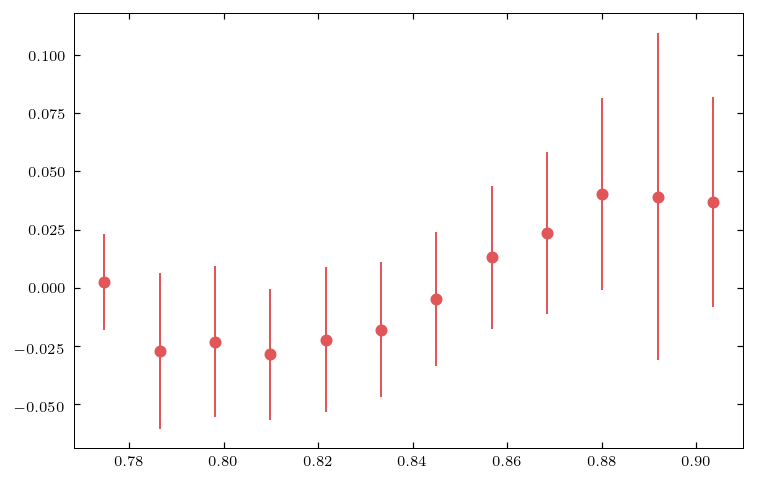

In [18]:
fig,ax = plt.subplots(1)

ax.errorbar((bin_edges[1:]+bin_edges[:-1])/2,mean,yerr=std,fmt='o')

In [19]:
pearsonr(np.log10(catalogue['ionization']),catalogue['Z_local'])

(0.49292202468212515, 1.9811408149041511e-59)

In [ ]:
from astropy.coordinates import match_coordinates_sky, search_around_sky
#idxc, idxn, d2d, d3d = search_around_sky(nebulae['SkyCoord'],clusters['SkyCoord'],max_sep_ang)

In [ ]:
cat = clusters[(clusters['age']>0) & (clusters['mass']>5e3)]

idx, sep2d, _ = match_coordinates_sky(nebulae['SkyCoord'],cat['SkyCoord'])

In [26]:
catalogue = clusters[(clusters['age']>0) & (clusters['age']<10) & (clusters['mass']>0)]

# define the maximum seperation
max_sep_dis = 30 * u.pc
max_sep_ang = 206265 * (max_sep_dis / Distance(distmod=galaxy.mu)).decompose() * u.arcsec

# the new columns we want to calculate
nearby_cluster = []       # list of clusters within max_sep_ang
N_nearby_cluster = []     # number of nearby clusters
sep = []                  # distance to the nearest cluster
age = []                  # age of nearest cluster (not NaN)
mass = []                 # mass of nearest cluster (not NaN)
mass_dis = []             # distance weighted mass
for row in nebulae:
    
    separation = row['SkyCoord'].separation(catalogue['SkyCoord'])
    # mask for all clusters within max_sep_dis
    mask = separation.__lt__(max_sep_ang)

    cluster_sub = catalogue[mask]
    
    N_nearby_cluster.append(np.sum(mask))
    nearby_cluster.append('')
    
    if len(cluster_sub) > 0:
        sep.append(np.min(separation[mask]))
        age.append(np.mean(cluster_sub['age']))
        mass.append(np.sum(cluster_sub['mass']))
        mass_dis.append(np.sum(cluster_sub['mass']/separation[mask]**2).value)
    else:
        sep.append(np.inf)
        age.append(np.inf)
        mass.append(0)
        mass_dis.append(0)
        
#catalogue['nearby_clusters'] = nearby_cluster
nebulae['N_nearby_cluster'] = N_nearby_cluster
nebulae['sep'] = sep
nebulae['age'] = age
nebulae['mass'] = mass
nebulae['mass_dis'] = mass_dis


In [29]:
nebulae[nebulae['N_nearby_cluster']>2]

ID,x,y,Z,Z_local,ionization,SkyCoord,N_nearby_cluster,sep,age,mass,mass_dis
,,,,,,"deg,deg",,,,,
float64,float64,float64,float64,float64,float64,object,int32,object,float64,float64,float64
2.0,163.74878924738252,396.0557104870233,8.590618238664963,0.03734633455334446,7.607920357657436,"65.02959793375096,-54.94081575611737",3,0d00m00.0684s,8.0,9086.188955319893,11261646551139.18
16.0,390.78773458712595,670.0263305489444,8.551492222182285,-0.018731485216941124,7.1698799075210795,"65.00763754270658,-54.92559819226755",3,0d00m00.1844s,1.0,17352.404283078085,4705756644263.633
61.0,215.54085107035334,194.1976966698029,8.573222274452657,0.03286162647859037,7.389101317962287,"65.02459518773253,-54.95203112767853",3,0d00m00.0134s,6.0,12016.453116027815,605127195919808.9
71.0,320.02150677862517,808.0090548336151,8.583191415241725,0.04418468984349211,7.657484282220327,"65.01447673574798,-54.91793196777296",3,0d00m00.0928s,1.0,124568.4420298616,83746111988749.95
75.0,396.37951886137665,975.1647659816991,8.564787268867232,0.05755235642545564,7.236505571811913,"65.00709471490083,-54.9086460839768",4,0d00m00.0728s,1.75,11471.086081897982,10573279067705.71
93.0,676.5755812676019,610.6398293856095,8.57797524749045,0.02179128856359469,7.505752979589134,"64.98000608764123,-54.928895626698925",3,0d00m00.0905s,1.0,34287.660963419716,32456699543448.83
163.0,323.0247835633408,176.8001481117835,8.543458975934426,-0.008139378376665007,6.769686824909558,"65.01419721972687,-54.952999157080974",3,0d00m00.0344s,1.0,29726.30160539283,129087817538417.1
195.0,479.8237028111717,583.5067425546114,8.603052142815896,0.014900499722228844,7.243406051402822,"64.99902930529647,-54.930404942336324",3,0d00m00.1536s,1.0,23622.222619669883,7211786409904.662


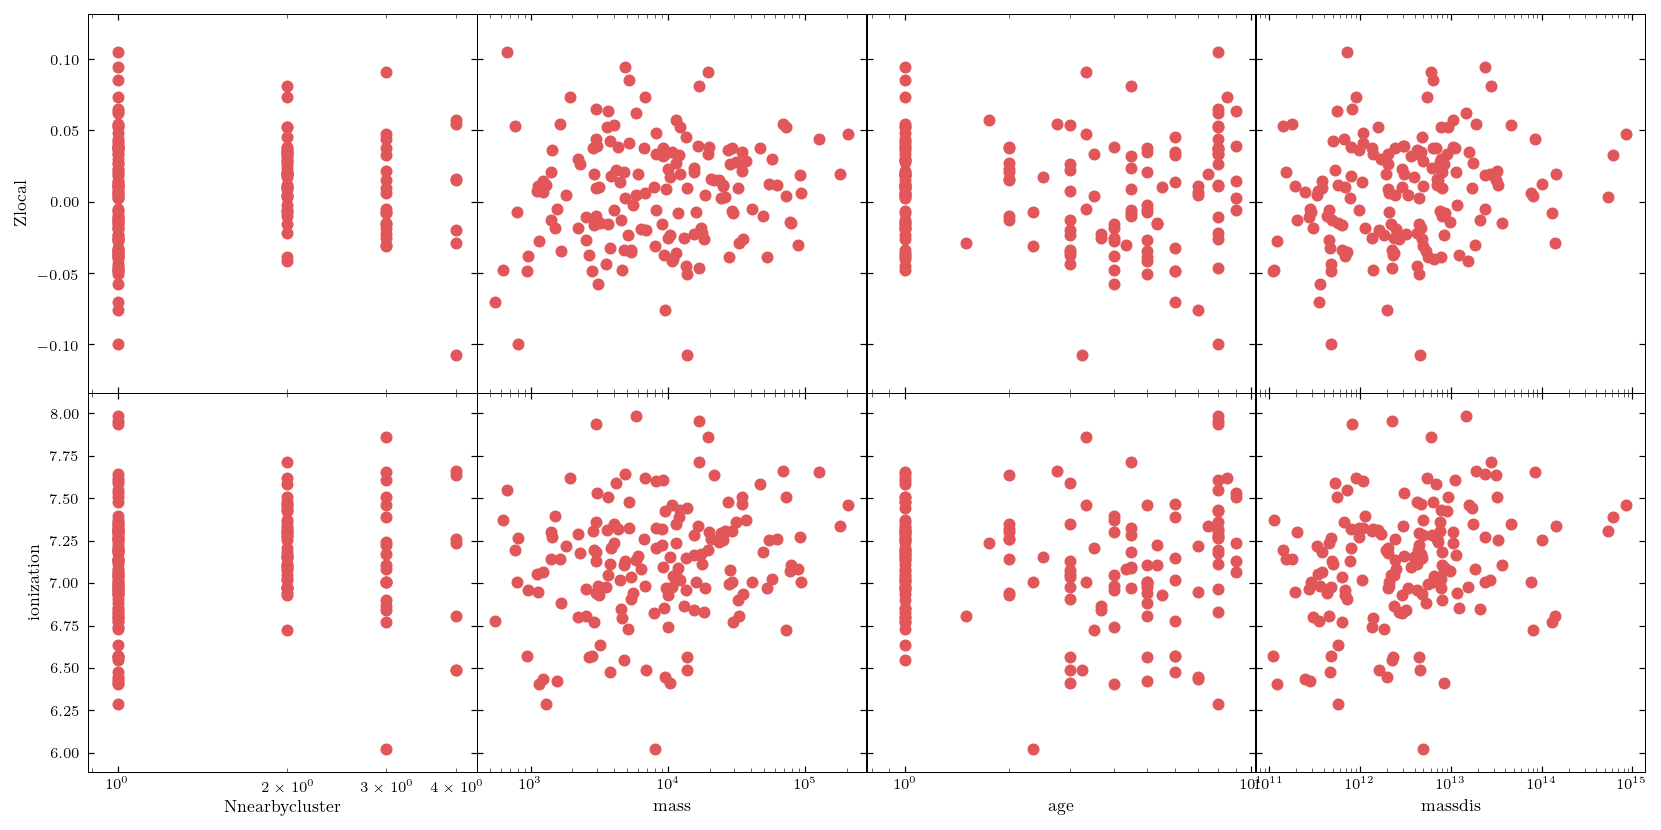

In [33]:
def plot_corner(table,rows,columns):
    '''plot rows against columns'''
    
    if set(rows)-set(table.columns):
        raise ValueError(f'missing column: {set(rows)-set(table.columns)}')
    if set(columns)-set(table.columns):
        raise ValueError(f'missing column: {set(columns)-set(table.columns)}')
        
        
    fig, axes = plt.subplots(nrows=len(rows),ncols=len(columns),
                             sharex='col',sharey='row',
                             figsize=(2*two_column,2*two_column*len(rows)/len(columns)))
    
    for i,col in enumerate(columns):
        for j,row in enumerate(rows):
            tmp = table[(table[col]>0)]
            
            ax = axes[j,i]
            ax.scatter(tmp[col],tmp[row])
                
            if j==len(rows)-1:
                ax.set_xlabel(col.replace('_',''))
                ax.set_xscale('log')
            if i%len(columns)==0:
                ax.set_ylabel(row.replace('_',''))
                #ax.set_ylim([np.nanpercentile(tmp[row],1),np.nanpercentile(tmp[row],99)])
                
    plt.subplots_adjust(hspace = .001)      
    plt.subplots_adjust(wspace = .001)      

    plt.show()
            
    
plot_corner(nebulae[nebulae['N_nearby_cluster']>0],rows=['Z_local','ionization'],columns=['N_nearby_cluster','mass','age','mass_dis'])

In [ ]:
from pymuse.detection import match_catalogues

idx, sep = match_catalogues(clusters[['x','y']],nebulae[['x','y']])

tolerance = 5
within_tolerance = len(sep[sep<tolerance])

print(f'{within_tolerance} of {len(sep)} clusters have an HII-region within {tolerance} pixel ({within_tolerance / len(sep)*100:.1f} %)')
print(f'mean seperation is {sep[sep<tolerance].mean():.2f} pixel')

clusters['sep'] = sep
clusters['Z'] = nebulae[idx]['met_scal']
clusters['ionization'] = nebulae[idx]['met_scal']
clusters['Z_without_radial'] = nebulae[idx]['Delta_met']

In [ ]:
from pymuse.plot.plot import create_RGB

#HII = nebulae[nebulae['HII_region_class']==1]

fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection=galaxy.wcs)

norm = simple_norm(galaxy.OIII5006_DAP,clip=False,percent=99)
#img = create_RGB(galaxy.HA6562,galaxy.OIII5006_DAP,galaxy.SII6716,weights=[0.6,1,0.6],percentile=[95,99.,95])
#ax.imshow(galaxy.OIII5006_DAP,norm=norm,cmap=plt.cm.Blues)
#ax.imshow(img)

ax.scatter(clusters['x'],clusters['y'],marker='o',s=3,lw=0.3,color='black',alpha=0.9,label='cluster')
im = ax.scatter(nebulae['x'],nebulae['y'],marker='o',s=5,lw=0.3,
           c=nebulae['Delta_met'], cmap=plt.cm.coolwarm,alpha=0.9,label='nebulae')
plt.colorbar(im)
plt.legend()
print(f'{len(nebulae)} HII regions\n{len(clusters)} Clusters')

filename = basedir / 'reports' / 'cluster' / 'clusters+HII.pdf'
plt.savefig(filename,bbox_inches='tight',dpi=600)

## Reproject 

In [ ]:
from reproject import reproject_interp

In [ ]:
# interpolate the HST data onto the MUSE image
hst_to_muse , hst_to_muse_footprint = reproject_interp(hst_whitelight,muse_whitelight.meta)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(121,projection=muse_whitelight.wcs)
ax2 = fig.add_subplot(122,projection=muse_whitelight.wcs)

norm = simple_norm(hst_to_muse,'linear',clip=False,percent=99)
ax1.imshow(hst_to_muse,norm=norm)

ax2.imshow(hst_to_muse_footprint)

plt.show()

In [ ]:
# interpolate the MUSE data onto the HST image
muse_to_hst , muse_to_hst_footprint = reproject_interp(muse_whitelight,hst_whitelight.meta)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(121,projection=hst_whitelight.wcs)
ax2 = fig.add_subplot(122,projection=hst_whitelight.wcs)

norm = simple_norm(muse_to_hst,'linear',clip=False,percent=99)
ax1.imshow(muse_to_hst,norm=norm)

ax2.imshow(muse_to_hst_footprint)

plt.show()

## Starburst99

In [31]:
try:
    from starburst99.main import Cluster  
    from starburst99.io import read_starburst99
except ImportError:
    print('Package `starburst99` not installed')
    
star_path = Path('../../Starburst99/data')
noutput = 'cluster'

In [ ]:
def create_cluster(folder,**kwargs):

    parameters = {
    "name" : 'standard',
    "isf" : -1,
    "mass" : 1.,
    "sfr" : 1,
    "ninterv" : 2,
    "xponent" : '1.3,2.3',
    "xmaslim" : '0.1,0.5,120',
    "sncut" : 8.,
    "bhcut" : 120.,
    "model" : 64,
    "wind_model" : 0,
    "tinitial" : 0.01,
    "time_scale" : 0,
    "time_step" : 0.1,
    "n_steps" : 1000,
    "tmax" : 50,
    "jmg" : 3,
    "atmos" : 5,
    "metallicity" : 3,
    "uvline" : 1}

    # assign the new parameters
    for k,v in kwargs.items():
        if k in parameters:
            parameters[k] = v
    
    # open tempalte
    with open(basedir/'data'/'input.template') as f:
        template = f.read()
    
    template = template.format(**parameters)

    #write to templae
    with open(folder/'input.out','w') as f:
        f.write(template)
        
        


In [32]:
from starburst99.main import Cluster
        
cluster = Cluster()

In [ ]:
from starburst99.io import read

In [ ]:
def create_cluster(filename,**kwargs):


    parameters = {
    "name" : 'standard',
    "isf" : -1,
    "mass" : 1.,
    "sfr" : 1,
    "ninterv" : 2,
    "xponent" : '1.3,2.3',
    "xmaslim" : '0.1,0.5,120',
    "sncut" : 8.,
    "bhcut" : 120.,
    "model" : 64,
    "wind_model" : 0,
    "tinitial" : 0.01,
    "time_scale" : 0,
    "time_step" : 0.1,
    "n_steps" : 1000,
    "tmax" : 50,
    "jmg" : 3,
    "atmos" : 5,
    "metallicity" : 3,
    "uvline" : 1}

    # assign the new parameters
    for k,v in kwargs.items():
        if k in parameters:
            parameters[k] = v
    
    # open tempalte
    with open(star_path/'input.template') as f:
        template = f.read()
    
    template = template.format(**parameters)

    #write to templae
    with open(star_path/'input.out','w') as f:
        f.write(template)
        
create_cluster(None,model=34,sncut=12)

In [ ]:
from tkinter import filedialog

def file_save():
    f = filedialog.asksaveasfile(mode='w', defaultextension=".out")
    if f is None: # asksaveasfile return `None` if dialog closed with "cancel".
        return
    f.write(template)
    f.close() # `()` was missing.

In [ ]:

file_save()

In [ ]:
cluster1e4 = Cluster(star_path / 'GENEVA_v40_0.014_1e4Msun' / noutput)


In [ ]:
cluster1e4 = Cluster(star_path / 'GENEVA_v40_0.014_1e4Msun' / noutput)
cluster1e6 = Cluster(star_path / 'GENEVA_v40_0.014_1e6Msun' / noutput)
cluster_new = cluster1e4.scale(1e6)

### Compare results of the scaling

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

tablename = 'yields'

tbl1 = getattr(cluster1e4,tablename)
tbl2 = getattr(cluster1e6,tablename)
tbl3 = getattr(cluster_new,tablename)

for col in tbl1.columns[1:]:
    color = next(ax._get_lines.prop_cycler)['color']
    
    ax.plot(tbl1['Time'],tbl1[col],color=color,ls='--',label=col.replace('_',''))
    ax.plot(tbl2['Time'],tbl2[col],color=color,ls=':',lw=2)
    ax.plot(tbl3['Time'],tbl3[col],color=color,lw=0.5)

print('-- : 1e4, .. : 1e6, __ : scaled')
#ax.set_yscale('log')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()

tablename = 'yields'
column = 'O'
tbl1 = getattr(cluster1e4,tablename)
tbl2 = getattr(cluster1e6,tablename)
tbl3 = getattr(cluster_new,tablename)



color = next(ax._get_lines.prop_cycler)['color']
    
ax.plot(tbl1['Time'],tbl1[column],color=color,ls='--',label='1e4')
ax.plot(tbl2['Time'],tbl2[column],color=color,ls=':',lw=2,label='1e6')
ax.plot(tbl3['Time'],tbl3[column],color=color,lw=0.5,label='scaled')

plt.legend()
ax.set_yscale('log')
#plt.legend()
plt.show()